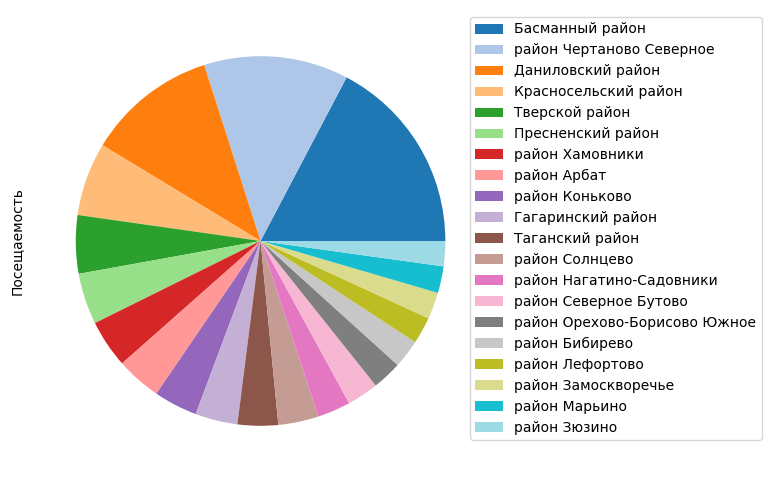

In [15]:
%matplotlib inline
from reportlab.pdfgen import canvas
from reportlab.lib import pagesizes
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.lib.utils import ImageReader
from PyPDF2 import PdfMerger, PdfReader
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def extract_district (x):
    return list(map(lambda a: a["District"], x))[0]
r = requests.get("https://video.ittensive.com/python-advanced/data-7361-2019-11-28.utf.json")
data = pd.DataFrame(json.loads(r.content)).fillna(value=0)
#после получения данных, группируем и сортируем в порядке убывания
data["District"] = data["ObjectAddress"].apply(extract_district)
data_sum = data.groupby("District").sum().sort_values("NumOfVisitors",
                                                     ascending=False)
#построим результирующую круговую диаграмму из 20-ти самых #популярных районов
fig = plt.figure(figsize=(11,6))
area = fig.add_subplot(1, 1, 1)
#для большей читаемости уберем районы из подписи на диаграмме задав пустые лейбы по числу районов
data_sum[0:20]["NumOfVisitors"].plot.pie(ax = area,
                                        labels=[""]*20,
                                        label="Посещаемость",
                                        cmap="tab20")

#перенесем все районы в легенду (это будет индекс)
plt.legend(data_sum[0:20].index,
          bbox_to_anchor=(1.5,1,0.1,0)) #легенда будет справа(сдвинем по оси Х)
plt.savefig("readers.png")# сохраним график для последующей ставки в отчет

#формирование отчета. Зададим шрифт, 
pdfmetrics.registerFont(TTFont("Trebuchet", "Trebuchet.ttf"))
# Зададим холст с размерами
PDF = canvas.Canvas("readers.pdf", pagesize=pagesizes.A2)
# размер шрифта и …
PDF.setFont("Trebuchet", 48)
PDF.drawString(70, 650, "Посетители библиотек")
PDF.drawString(80, 590, "по районам Москвы")
PDF.setFont("Trebuchet", 13)
PDF.drawString(550, 820, "2")
#вставим диаграмму через ранее сохраненное изображение
PDF.drawImage(ImageReader("readers.png"), -200, 150)
PDF.setFont("Trebuchet", 20)
PDF.drawString(100, 150, "Самый популярный район")
PDF.setFont("Trebuchet", 24)
PDF.drawString(100, 120, data_sum.index[0])
PDF.setFont("Trebuchet", 20)
PDF.drawString(100, 90,
               "Посетителей: " + str(int(data_sum["NumOfVisitors"].values[0])))
PDF.save()
files = ["title.pdf", "readers.pdf"]
#объединим отчет через PdfMerger
merger = PdfMerger()
for filename in files:
    merger.append(PdfReader(open(filename, "rb")))
merger.write("report.pdf")
